Implementation of a CNN in Keras for classification of Food-101 dataset


In [ ]:
## Unzipp to install this librairy

# !pip install livelossplot

In [ ]:
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os

import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2


from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

##### Downloading and preparing the dataset

In [ ]:
# #Uncomment to download the dataset

# !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

# !tar xzvf food-101.tar.gz ## Unzipp the dataset

 Splitting the data

In [ ]:
# Move data from images to images/train or images/test:

def split_dataset(root_food_path):
    """Takes in the path for food-101 directory and creates train/test dirs of images"""
    data_paths = {
        'train': root_food_path/'meta/train.json',
        'test': root_food_path/'meta/test.json'
    }
    for data_type, meta_path in data_paths.items():
        # Make the train/test dirs
        os.makedirs(root_food_path/data_type, exist_ok=True)

        # Read the meta files.
        # These are loaded as a dict of food names with a list of image paths
        # E.g. {"<food_name>": ["<food_name>/<image_num>", ...], ...}
        food_images = json.load(open(meta_path, 'r'))

        for food_name, image_paths in food_images.items():
            # Make food dir in train/test dir
            os.makedirs(root_food_path/data_type/food_name, exist_ok=True)

            # Move images from food-101/images to food-101/train (or test)
            for image_path in image_paths:
                image_path = image_path + '.jpg'
                shutil.move(root_food_path/'images'/image_path, root_food_path/data_type/image_path)


In [ ]:
download_dir = Path('/content/')

split_dataset(download_dir/'food-101')

### Preprocessing Image Data

 Increase the diversity of the training dataset, leading to better generalization and improved model performance.

In [ ]:
# Image augmentations

example_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)


In [ ]:
train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)


In [ ]:
class_subset = sorted(os.listdir(download_dir/'food-101/images'))[:10]

In [ ]:
class_subset

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

We have 10 classes of food

Data Generators for Image Augmentation and Loading in a Food Classification Model

In [ ]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory(download_dir/'food-101/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(download_dir/'food-101/test',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)


Found 6380 images belonging to 10 classes.
Found 370 images belonging to 10 classes.


### Writing our Model in Keras

In [ ]:
# Create a Sequential model for a Convolutional Neural Network (CNN)

# Initialize the Sequential model
model = Sequential()

#### Input Layer ####

# Add a convolutional layer with 32 filters, a kernel size of (3,3), 'same' padding,
# ReLU activation function, and input shape (128, 128, 3)
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####

# Add another convolutional layer with 32 filters, a kernel size of (3,3), and ReLU activation
model.add(Conv2D(32, (3,3), activation='relu'))
# Add a max pooling layer with a pool size of (2,2) for down-sampling
model.add(MaxPooling2D((2,2)))

# Add a dropout layer with a dropout rate of 20% for regularization
model.add(Dropout(0.2))

# Repeat similar blocks for additional convolutional layers

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####

# Flatten the output from the convolutional layers
model.add(Flatten())
# Add a fully-connected layer with 1024 units and ReLU activation
model.add(Dense(1024, activation='relu'))
# Add a dropout layer with a dropout rate of 20% for regularization
model.add(Dropout(0.2))
# Add the final fully-connected layer with units equal to the number of classes, with
# softmax activation function for multi-class classification
model.add(Dense(len(class_subset), activation='softmax'))

# Display a summary of the model architecture
model.summary()  # a handy way to inspect the architecture


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

Trainning

##### Set up and train the neural network model

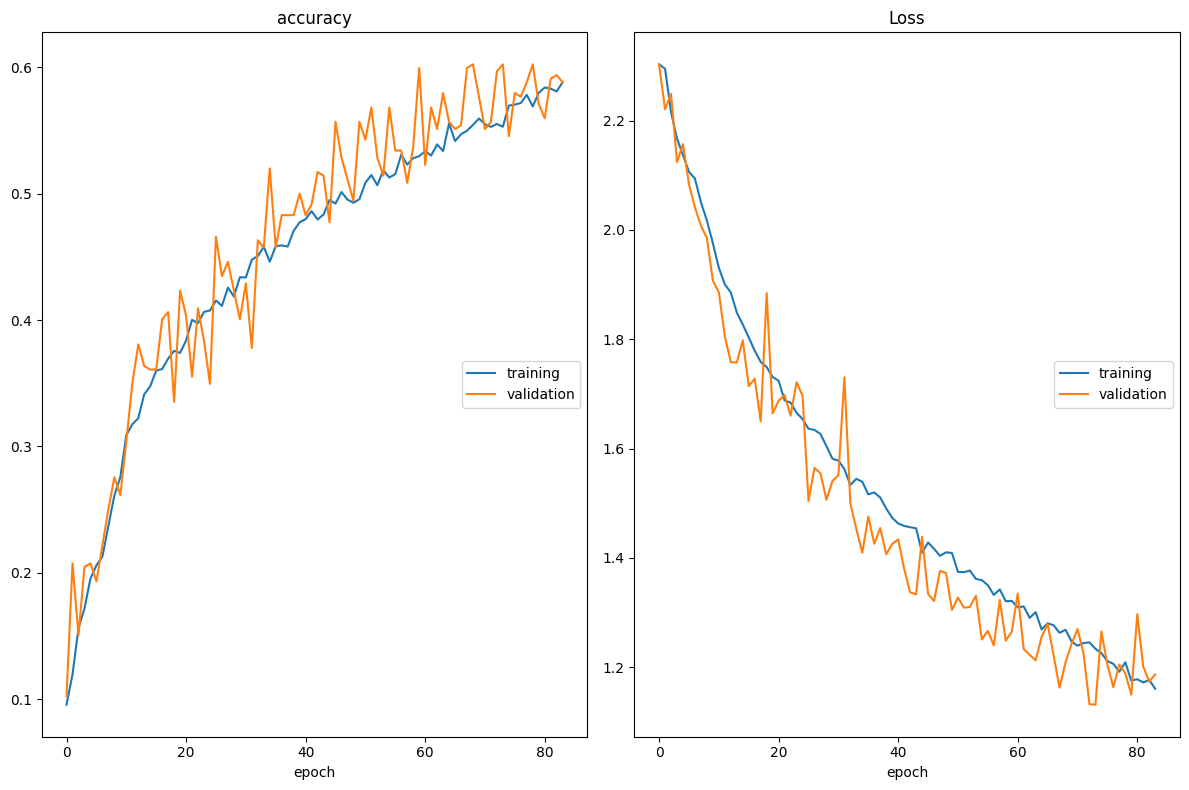

accuracy
	training         	 (min:    0.096, max:    0.588, cur:    0.588)
	validation       	 (min:    0.102, max:    0.602, cur:    0.588)
Loss
	training         	 (min:    1.161, max:    2.303, cur:    1.161)
	validation       	 (min:    1.132, max:    2.302, cur:    1.187)
CPU times: user 1h 27min 26s, sys: 1min 9s, total: 1h 28min 35s
Wall time: 1h 31min 46s


In [ ]:
%%time

# Calculate the number of steps per epoch based on the training set size and batch size
steps_per_epoch = traingen.samples // BATCH_SIZE

# Calculate the number of validation steps based on the validation set size and batch size
val_steps = validgen.samples // BATCH_SIZE

# Number of training epochs
n_epochs = 100

# Define the optimizer with a learning rate of 0.0001
optimizer = RMSprop(learning_rate=0.0001)

# Compile the model with categorical crossentropy loss, RMSprop optimizer, and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Save the model weights after each epoch if it achieves the best validation loss so far
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

# Apply early stopping to prevent overtraining and restore the best weights when triggered
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Actual training of the model using the fit method
history = model.fit(traingen,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)


We can said that before 85 epochs our model is trying to generalize on the val set, but after it start over training, that is why the early stopping is applied at this stage. The model performance is 58.8% on the training  and  validation set.

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'food-101/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset,
                                             shuffle=False,
                                             seed=42)

# !tar xzvf food-101.tar.gz

Found 2500 images belonging to 10 classes.


In [ ]:
model.load_weights('img_model.weights.best.hdf5')

# predicted_classes = model.predict_classes(testgen)
predicted_probabilities = model.predict(testgen)

predicted_classes = predicted_probabilities.argmax(axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

2500/2500 [==============================] - 13s 5ms/step


In [ ]:

def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)

    results.sort_values(by='F-Score', ascending=False, inplace=True)
    global_acc = accuracy_score(y_true, y_preds)

    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))


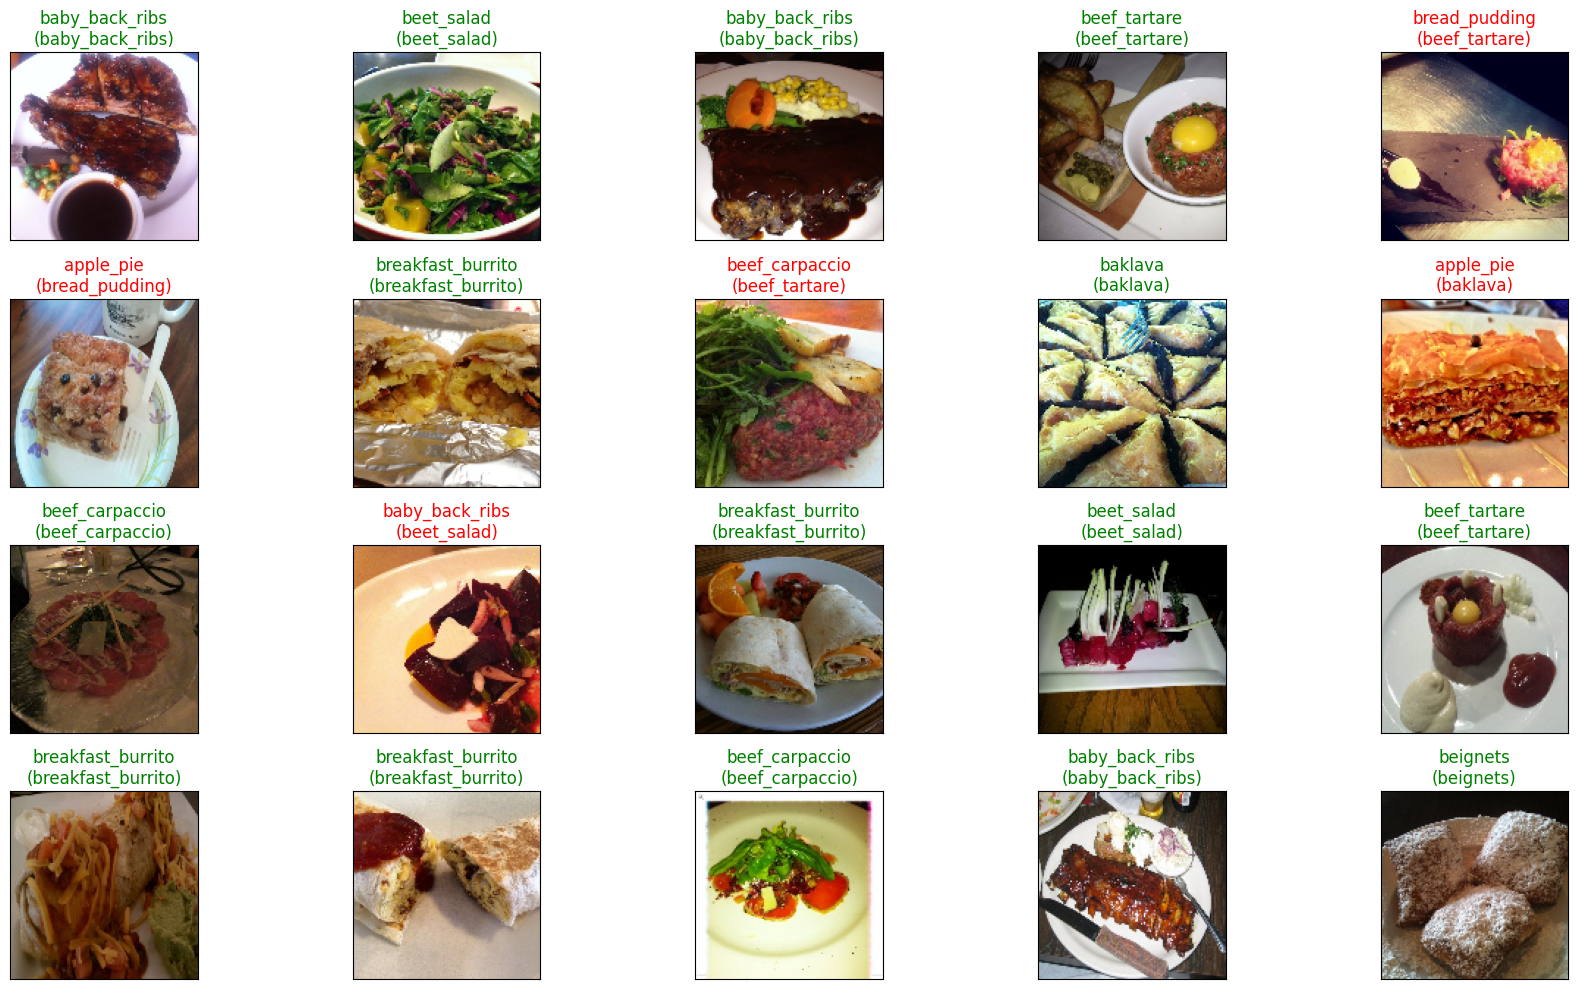

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

##### After the prediction, we observe that our model predicted 15 corrected images out of 20

In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())


Overall Categorical Accuracy: 56.76%


,Precision,Recall,F-Score,Support
beef_carpaccio,0.761719,0.780,0.770751,250.0
bibimbap,0.666667,0.784,0.720588,250.0
beet_salad,0.819672,0.600,0.692841,250.0
beignets,0.559055,0.852,0.675119,250.0
baby_back_ribs,0.492754,0.816,0.614458,250.0
beef_tartare,0.611374,0.516,0.559653,250.0
baklava,0.419271,0.644,0.507886,250.0
breakfast_burrito,0.453271,0.388,0.418103,250.0
apple_pie,0.431579,0.164,0.237681,250.0
bread_pudding,0.485294,0.132,0.207547,250.0
